## Import relevant libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# import dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00471/Data_for_UCI_named.csv'
df = pd.read_csv(url)
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


## Preprocess the data

In [3]:
# save data to local machine
df.to_csv('Data_for_UCI_named.csv')

In [4]:
# drop the numerical target variable (stab)
df = df.drop(['stab'], axis=1)

In [5]:
# split data into train and test sets
train, test = train_test_split(df, test_size=.2, random_state=1)

In [6]:
# split out predictors and target variables from datasets
x_train = train.drop(['stabf'], axis=1)
y_train = train['stabf']
x_test = test.drop(['stabf'], axis=1)
y_test = test.stabf
x_train.head(2)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
2694,6.255995,2.542401,7.024714,9.476518,3.529888,-1.224881,-0.688228,-1.616780,0.568221,0.618403,0.685739,0.660088
5140,5.070581,5.490253,8.075688,0.761075,4.220888,-1.280596,-1.902185,-1.038107,0.443515,0.097244,0.916955,0.129254


In [7]:
# Scaled the predictors (train and test)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled

array([[ 0.36732671, -0.98604156,  0.65044706, ...,  0.33985949,
         0.58556788,  0.49223946],
       [-0.06465869,  0.08943734,  1.03507899, ..., -1.5584875 ,
         1.42964862, -1.44352101],
       [-1.46785   ,  1.29841758, -0.50253617, ...,  1.45153362,
        -1.04574277,  0.49248925],
       ...,
       [ 0.65760851, -0.72275633, -1.4058879 , ...,  0.29310048,
        -1.55058661,  0.81034412],
       [-0.05931596, -1.26053241, -1.01047147, ..., -0.38825455,
        -0.72678059,  1.66791568],
       [-1.47321368,  0.63843757,  0.25012249, ..., -1.17410957,
         1.179282  ,  0.78362657]])

## spot check the algorithms on the dataset using k=5 fold cross validation

In [22]:
rfc = RandomForestClassifier()
rfc.fit(x_train_scaled, y_train)
rfc_pred = rfc.predict(x_test_scaled)
print(accuracy_score(y_test, rfc_pred))

0.923


In [23]:
etc = ExtraTreesClassifier()
etc.fit(x_train_scaled, y_train)
etc_pred = etc.predict(x_test_scaled)
print(accuracy_score(y_test, etc_pred))

0.926


In [24]:
xgb = XGBClassifier()
xgb.fit(x_train_scaled, y_train)
xgb_pred = xgb.predict(x_test_scaled)
print(accuracy_score(y_test, xgb_pred))

0.9195


In [25]:
lgm = LGBMClassifier()
lgm.fit(x_train_scaled, y_train)
lgm_pred = lgm.predict(x_test_scaled)
print(accuracy_score(y_test, lgm_pred))

0.9375


## Hyperparameter tuning

##### Tuning extra trees classifier

In [30]:
# instantiate model
etc_model = ExtraTreesClassifier()

# set hyperparameters
n_estimators = [50, 100, 300, 500, 1000]

min_samples_split = [2, 3, 5, 7, 9]

min_samples_leaf = [1, 2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None] 

hyperparam_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

seed = 1
num_fold = 5
scoring = 'accuracy'

# run randomsearch
kfold = KFold(n_splits=num_fold)
grid_search = RandomizedSearchCV(estimator=etc_model,
                                 param_distributions=hyperparam_grid,
                                 scoring=scoring, random_state=seed,
                                 cv=kfold, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


In [31]:
# print results
print("Best ROC_AUC: %f using %s" % (grid_result.best_score_,
                                     grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best ROC_AUC: 0.925250 using {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}
0.918000 (0.009265) with: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}
0.906375 (0.006090) with: {'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2'}
0.922000 (0.008305) with: {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto'}
0.918250 (0.008842) with: {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'auto'}
0.925250 (0.006502) with: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}
0.922875 (0.005193) with: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None}
0.909625 (0.010059) with: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}
0.919500 (0.006427) with: {'n_estimators': 100, 'mi

##### Tuning random forest classifier

In [32]:
# tuning RandomForest Classifier
rfc = RandomForestClassifier()

# set hyperparameters
hyperparam_grid = {'n_estimators': [50, 100, 300, 500, 1000],
                   'min_samples_split': [2, 3, 5, 7, 9],
                   'min_samples_leaf': [1, 2, 4, 6, 8],
                   'max_features': ['auto', 'sqrt', 'log2', None]}


seed = 1
num_fold = 5
scoring = 'accuracy'

# run randomsearch
kfold = KFold(n_splits=num_fold)
grid_search = RandomizedSearchCV(estimator=rfc,
                                 param_distributions=hyperparam_grid,
                                 scoring=scoring, random_state=seed,
                                 cv=kfold, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(x_train_scaled, y_train)

# print results
print("Best ROC_AUC: %f using %s" % (grid_result.best_score_,
                                     grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.1min finished


Best ROC_AUC: 0.918750 using {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto'}
0.916750 (0.006476) with: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}
0.912375 (0.007218) with: {'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2'}
0.918750 (0.006085) with: {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto'}
0.918625 (0.005006) with: {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'auto'}
0.910000 (0.004348) with: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}
0.908125 (0.007685) with: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None}
0.912500 (0.008263) with: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}
0.918125 (0.007458) with: {'n_estimators': 100, 'm

## Retrain Model with Best Hyperparameters and Predict on Test Set

In [33]:
models = []

models.append(('RFC',
               RandomForestClassifier(n_estimators=1000,
                                      min_samples_split= 5,
                                      min_samples_leaf=2,
                                      max_features='sqrt')))
models.append(('ETC',
               ExtraTreesClassifier(n_estimators=1000,
                                    min_samples_split= 2,
                                    min_samples_leaf=8,
                                    max_features=None)))


report = []
conf_matrix = []
names = []
accuracy = []

for name, model in models:
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    names.append(name)
    conf_matrix.append(confusion_matrix(y_test, y_pred))
    report.append(classification_report(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))

In [43]:
print('Report for RandomForestClassifier:')
print(conf_matrix[0])
print(report[0])
print('Accuracy:', accuracy[0])

Report for RandomForestClassifier:
[[ 618   94]
 [  62 1226]]
              precision    recall  f1-score   support

      stable       0.91      0.87      0.89       712
    unstable       0.93      0.95      0.94      1288

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000

Accuracy: 0.922


In [44]:
print('Report for ExtraTreesClassifier:')
print(conf_matrix[1])
print(report[1])
print('Accuracy:', accuracy[1])

Report for ExtraTreesClassifier:
[[ 620   92]
 [  54 1234]]
              precision    recall  f1-score   support

      stable       0.92      0.87      0.89       712
    unstable       0.93      0.96      0.94      1288

    accuracy                           0.93      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.93      0.93      0.93      2000

Accuracy: 0.927


## Analysing Feature Importance

In [39]:
df.head(2)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable


Feature: 0, Score: 0.13780
Feature: 1, Score: 0.14069
Feature: 2, Score: 0.13444
Feature: 3, Score: 0.13472
Feature: 4, Score: 0.00374
Feature: 5, Score: 0.00529
Feature: 6, Score: 0.00535
Feature: 7, Score: 0.00502
Feature: 8, Score: 0.10283
Feature: 9, Score: 0.10770
Feature: 10, Score: 0.11280
Feature: 11, Score: 0.10962


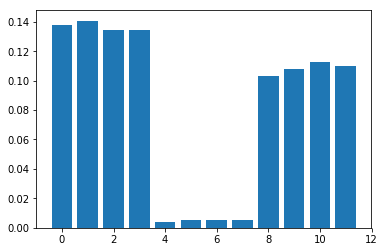

In [38]:
# define the model
etc = ExtraTreesClassifier(n_estimators=1000,
                           min_samples_split= 2,
                           min_samples_leaf=8,
                           max_features=None)
# fit the model
etc.fit(x_train_scaled, y_train)
# get importance
importance = etc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Calculating F1 Score - Question 1

In [40]:
precision = 355 / (355 + 1480)
recall = 355 / (355 + 45)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)

0.3176733780760626
